# Counting Triangles

In [1]:
# IMPORTS AND GLOBALS

import numpy as np
from matplotlib import pyplot as plt
from multiprocessing import Process
from multiprocessing import Manager
import time

ds_size = 198110
output_dir = '../output/'
sample_sizes = [5000, 10000, 20000, 30000, 40000]
sample_labels = ["solid", "dashed", "dotted", "dashdot", (0, (5, 10))]

start_time = time.time()


In [4]:
# GET OUTPUTS; THEN GET MIN, MAX, MEDIAN, FIRST Q, THIRD Q METHODS

def get_outputs(dict, impr=False):

    outputs = np.empty((ds_size, 5, 20))

    k = 0
    for i in sample_sizes:

        for j in range(0,20):
            
            if impr:
                output_file = output_dir + "output." + str(i) + "I." + str(j) + ".txt"
            else:
                output_file = output_dir + "output." + str(i) + "." + str(j) + ".txt"
            
            with open(output_file, "rt") as file:
                line_num = 0
                for line in file:
                    outputs[line_num][k][j] = line
                    line_num += 1
        
        k += 1
    
    if impr:
        dict['i'] = outputs
    else:
        dict['b'] = outputs


def get_min(outputs, dict, impr=False):
    min_l = np.empty((5, ds_size))
    for t in range(0, ds_size):
        for i in range(0,5):
            
            t_list = np.empty(20)

            for j in range(0,20):
                t_list[j] = int(outputs[t][i][j])
            
            # append min
            min_l[i][t] = np.amin(t_list)
    key = 'min_l'
    if impr:
        key += "_i"        
    dict[key] = min_l


def get_max(outputs, dict, impr=False):
    max_l = np.empty((5, ds_size))
    for t in range(0, ds_size):
        for i in range(0,5):
            
            t_list = np.empty(20)

            for j in range(0,20):
                t_list[j] = int(outputs[t][i][j])
            
            # append min
            max_l[i][t] = np.amax(t_list)
    key = 'max_l'
    if impr:
        key += "_i"        
    dict[key] = max_l


def get_median(outputs, dict, impr=False):
    median_l = np.empty((5, ds_size))
    for t in range(0, ds_size):
        for i in range(0,5):
            
            t_list = np.empty(20)

            for j in range(0,20):
                t_list[j] = int(outputs[t][i][j])
            
            # append min
            median_l[i][t] = np.median(t_list)
    key = 'median_l'
    if impr:
        key += "_i"        
    dict[key] = median_l


def get_first(outputs, dict, impr=False):
    first = np.empty((5, ds_size))
    for t in range(0, ds_size):
        for i in range(0,5):
            
            t_list = np.empty(20)

            for j in range(0,20):
                t_list[j] = int(outputs[t][i][j])
            
            # append first quantile
            first[i][t] = np.quantile(t_list,0.25)
    key = 'first'
    if impr:
        key += "_i"        
    dict[key] = first


def get_third(outputs, dict, impr=False):
    third = np.empty((5, ds_size))
    for t in range(0, ds_size):
        for i in range(0,5):
            
            t_list = np.empty(20)

            for j in range(0,20):
                t_list[j] = int(outputs[t][i][j])
            
            # append third quantile
            third[i][t] = np.quantile(t_list,0.75)
    key = 'third'
    if impr:
        key += "_i"        
    dict[key] = third
        

In [5]:
manager = Manager()
dict = manager.dict()

pb = Process(target=get_outputs, args=(dict,)); pb.start()
pi = Process(target=get_outputs, args=(dict, True)); pi.start()

pb.join(); pi.join()

outputs_b = dict['b']
outputs_i = dict['i']

p1 = Process(target=get_min, args=(outputs_b, dict)); p1.start()
p2 = Process(target=get_max, args=(outputs_b, dict)); p2.start()
p3 = Process(target=get_median, args=(outputs_b, dict)); p3.start()
p4 = Process(target=get_first, args=(outputs_b, dict)); p4.start()
p5 = Process(target=get_third, args=(outputs_b, dict)); p5.start()
p6 = Process(target=get_min, args=(outputs_i, dict, True)); p6.start()
p7 = Process(target=get_max, args=(outputs_i, dict, True)); p7.start()
p8 = Process(target=get_median, args=(outputs_i, dict, True)); p8.start()
p9 = Process(target=get_first, args=(outputs_i, dict, True)); p9.start()
p10 = Process(target=get_third, args=(outputs_i, dict, True)); p10.start()

p1.join(); p2.join(); p3.join(); p4.join(); p5.join(); p6.join(); p7.join(); p8.join(); p9.join(); p10.join()

min_l = dict['min_l']; max_l = dict['max_l']; median_l = dict['median_l']; first = dict['first']; third = dict['third']
min_l_i = dict['min_l_i']; max_l_i = dict['max_l_i']; median_l_i = dict['median_l_i']; first_i = dict['first_i']; third_i = dict['third_i']


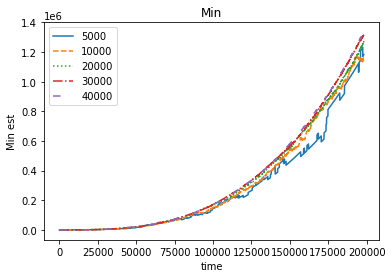

In [6]:
for i in range(0,5):
    plt.plot(range(0,ds_size), min_l[i], 
             label=str(sample_sizes[i]), linestyle=sample_labels[i])

plt.title("Min")
plt.xlabel("time")
plt.ylabel("Min est")
plt.legend()
plt.show()

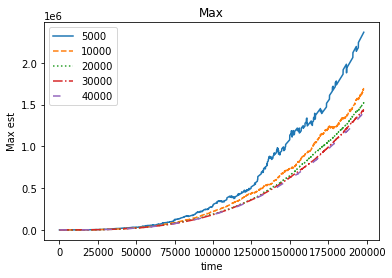

In [7]:
for i in range(0,5):
    plt.plot(range(0,ds_size), max_l[i],
             label=str(sample_sizes[i]), linestyle=sample_labels[i])

plt.title("Max")
plt.xlabel("time")
plt.ylabel("Max est")
plt.legend()
plt.show()

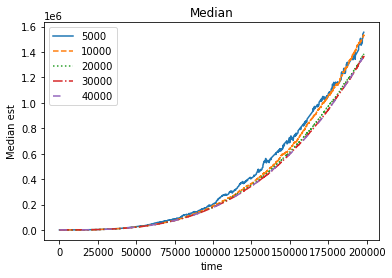

In [8]:
for i in range(0,5):
    plt.plot(range(0,ds_size), median_l[i],
             label=str(sample_sizes[i]), linestyle=sample_labels[i])

plt.title("Median")
plt.xlabel("time")
plt.ylabel("Median est")
plt.legend()
plt.show()

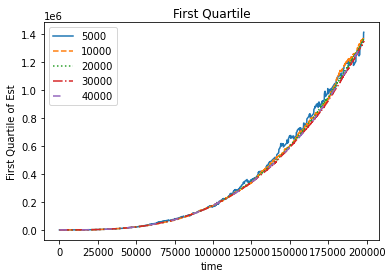

In [9]:
for i in range(0,5):
    plt.plot(range(0,ds_size),first[i],
             label=str(sample_sizes[i]), linestyle=sample_labels[i])

plt.title("First Quartile")
plt.xlabel("time")
plt.ylabel("First Quartile of Est")
plt.legend()
plt.show()

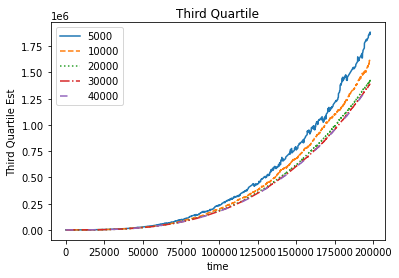

In [10]:
for i in range(0,5):
    plt.plot(range(0,ds_size), third[i],
             label=str(sample_sizes[i]), linestyle=sample_labels[i])

plt.title("Third Quartile")
plt.xlabel("time")
plt.ylabel("Third Quartile Est")
plt.legend()
plt.show()

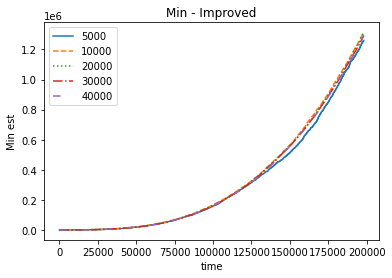

In [11]:
# IMPROVED 

for i in range(0,5):
    plt.plot(range(0,ds_size), min_l_i[i], 
             label=str(sample_sizes[i]), linestyle=sample_labels[i])

plt.title("Min - Improved")
plt.xlabel("time")
plt.ylabel("Min est")
plt.legend()
plt.show()

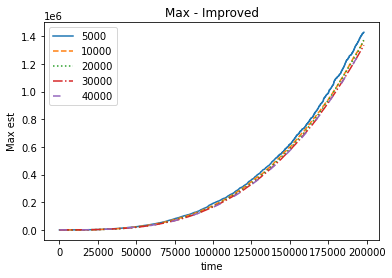

In [12]:
for i in range(0,5):
    plt.plot(range(0,ds_size), max_l_i[i],
             label=str(sample_sizes[i]), linestyle=sample_labels[i])

plt.title("Max - Improved")
plt.xlabel("time")
plt.ylabel("Max est")
plt.legend()
plt.show()

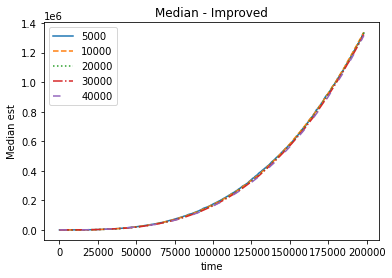

In [13]:
for i in range(0,5):
    plt.plot(range(0,ds_size), median_l_i[i],
             label=str(sample_sizes[i]), linestyle=sample_labels[i])

plt.title("Median - Improved")
plt.xlabel("time")
plt.ylabel("Median est")
plt.legend()
plt.show()

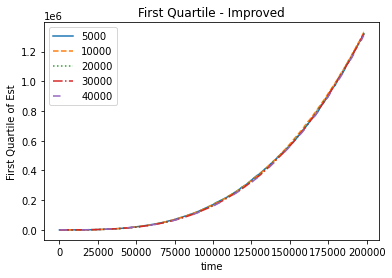

In [14]:
for i in range(0,5):
    plt.plot(range(0,ds_size),first_i[i],
             label=str(sample_sizes[i]), linestyle=sample_labels[i])

plt.title("First Quartile - Improved")
plt.xlabel("time")
plt.ylabel("First Quartile of Est")
plt.legend()
plt.show()

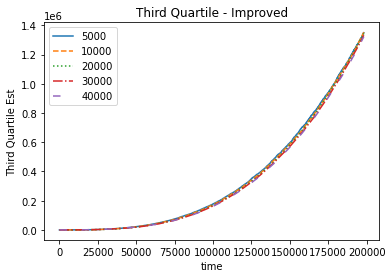

In [15]:
for i in range(0,5):
    plt.plot(range(0,ds_size), third_i[i],
             label=str(sample_sizes[i]), linestyle=sample_labels[i])

plt.title("Third Quartile - Improved")
plt.xlabel("time")
plt.ylabel("Third Quartile Est")
plt.legend()
plt.show()

In [16]:
end_time = time.time()
print(end_time - start_time)

198.2165012359619
